# TTT4275 Classification Project: Music Classification

In [22]:
# Imports
import source.data_handling
import source.mappings
import source.plotting
import source.diy_classifiers

import numpy as np
import sklearn.preprocessing

# uncomment following line and restart the kernel for interactive plots 
#%matplotlib notebook

## Task 1

Using only the four features given in task 1a), we plot the confusion matrix and error rate for all genres.

Error Rate: 67.17 %


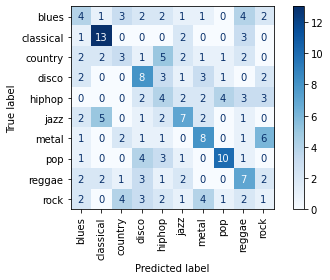

In [16]:
# kNN parameters
k = 5
features_task_1 = ["spectral_rolloff_mean", "tempo", "spectral_centroid_mean", "mfcc_1_mean"]

data_version = source.data_handling.GENRE_CLASS_DATA_30S
data_frame = source.data_handling.read_genre_class_data(data_version)

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    features=features_task_1,
    scaler=sklearn.preprocessing.MinMaxScaler(),
)

classifier = source.diy_classifiers.kNN(k=5, p=2)
classifier.fit(data_frame_x=training_data.x, data_frame_y=training_data.y)
y_pred_task1 = classifier.predict(test_data.x)

y_true_task1 = test_data.y

error_rate = source.descriptive_statistics.classifier_error_rate(
    predicted_genres=y_pred_task1,
    actual_genres=y_true_task1,
)
print(f"Error Rate: {error_rate:.2f} %")

source.plotting.confusion_matrix(y_true_task1, y_pred_task1, colorbar=True, cmap="Blues")

Then using the same data for sklearn's KNN gives us

Error Rate: 68.69 %


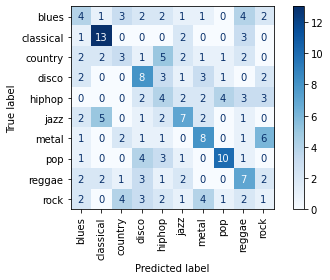

In [17]:
classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, p=2)
classifier.fit(X=training_data.x, y=training_data.y)
y_pred_task1_ref = classifier.predict(test_data.x)
y_true_task1_ref = test_data.y

error_rate = source.descriptive_statistics.classifier_error_rate(
    predicted_genres=y_pred_task1_ref,
    actual_genres=y_true_task1_ref,
)
print(f"Error Rate: {error_rate:.2f} %")

source.plotting.confusion_matrix(y_true_task1, y_pred_task1, colorbar=True, cmap="Blues")

We can plot some of the misclassifications and attempt to visualize why certain data points are falsely classified.

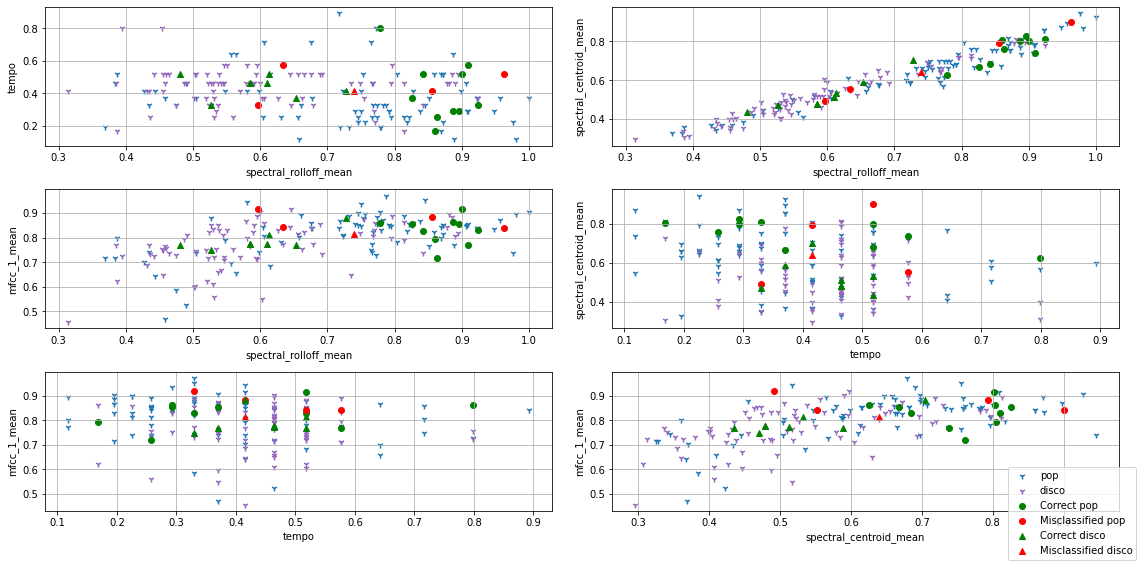

In [23]:
genre_combos = [["pop", "disco"]]

def apply_indices_to_dataset(
    data_set,
    indices,
):
    data_set.x = data_set.x.iloc[indices]
    data_set.y = data_set.y.iloc[indices]
    data_set.track_ids = data_set.track_ids.iloc[indices]
    
    return data_set

for combo in genre_combos:
    # Filter out all indices that should be either of the two genres and are classified
    # as either of the two given genres
    train_genre_indices = np.flatnonzero(
        np.array(training_data.data_frame["Genre"] == combo[0])
        + np.array(training_data.data_frame["Genre"] == combo[1])
    )
    test_genre_indices = np.flatnonzero(
        np.array(test_data.data_frame["Genre"] == combo[0])
        + np.array(test_data.data_frame["Genre"] == combo[1])
    )
    
    result_indices = np.flatnonzero((y_pred_task1 == combo[0]) + (y_pred_task1 == combo[1])) 
    test_indices = list(filter(lambda x: x in test_genre_indices, result_indices))

    train_data_copy = copy.deepcopy(training_data)
    test_data_copy = copy.deepcopy(test_data)
    
    display()
    # Plot the training data for the two given genres and plot the data points
    # from the test data and if they were correctly / falsely classified
    source.plotting.misclassifications_scatter_plot(
        training_data=apply_indices_to_dataset(train_data_copy, train_genre_indices),
        test_data=apply_indices_to_dataset(test_data_copy, test_indices),
        predicted_genres=y_pred_task1[test_indices],
        features=features_task_1,
        genres=combo,
    )

### KNN Parameters
Using all features we plot the error rates with respect to the number of neighbors and using different orders of the Minkowski order (p).
Once for our own implementation of the kNN classifier

In [28]:
ks = np.arange(20) + 1
ps = np.arange(10) + 1

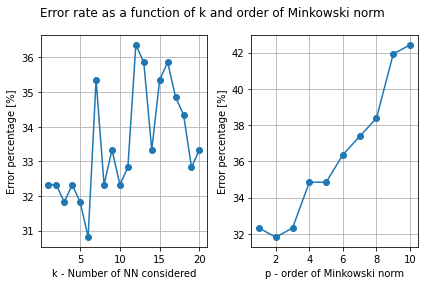

In [29]:
training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    scaler=sklearn.preprocessing.MaxAbsScaler(),
)

source.plotting.error_rates_vs_params(ks, ps, training_data, test_data, diy=True)

And another time for the sklearn implementation

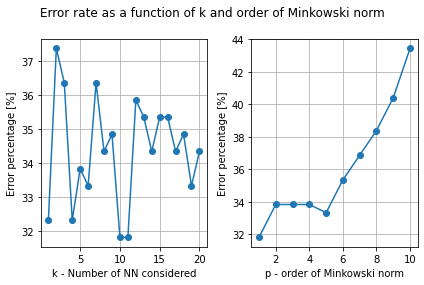

In [30]:
training_data, test_data = source.data_handling.prepare_data(
    data_frame=scaled_data_frame,
    scaler=sklearn.preprocessing.MaxAbsScaler(),
)

source.plotting.error_rates_vs_params(ks, ps, training_data, test_data, diy=False)

A larger number of neighbors to take into consideration could be beneficial when using KNN. Although the improvement is only small. Regarding the order of the Minkowski distance, interestingly the first order or Manhatten distance seems to perform the best and subsequent orders have worse error rates.
For both of these plots the improvement is not negligeable but small nonetheless.

## Task 2

In [25]:
features_task_2 = ["spectral_rolloff_mean", "tempo", "spectral_centroid_mean", "mfcc_1_mean"]
genres_task_2 = ["pop", "disco", "metal", "classical"]

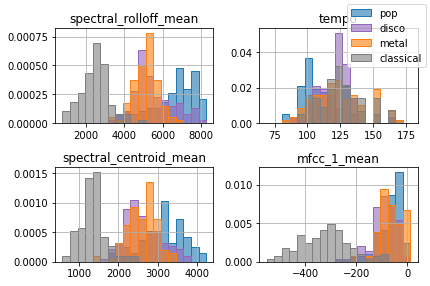

In [26]:
source.plotting.feature_distribution_histogram(
    data_frame=data_frame,
    features=features_task_2,
    genres=genres_task_2,
)

The main performance using the four genres and features given in task 2 is shown with the following code.

Error Rate: 27.85 %


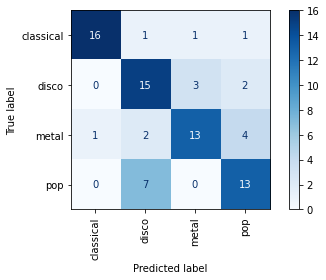

In [34]:
features_task_2 = ["spectral_rolloff_mean", "spectral_centroid_mean", "mfcc_1_mean", "tempo"]

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    genres=genres_task_2,
    features=features_task_2,
    scaler=sklearn.preprocessing.MinMaxScaler(),
)

classifier = source.diy_classifiers.kNN(k=5, p=2)
classifier.fit(data_frame_x=training_data.x, data_frame_y=training_data.y)
y_pred = classifier.predict(test_data.x)
y_true = test_data.y

error_rate = source.descriptive_statistics.classifier_error_rate(
    predicted_genres=y_pred,
    actual_genres=y_true,
)
print(f"Error Rate: {error_rate:.2f} %")

source.plotting.confusion_matrix(y_true_task1, y_pred_task1, colorbar=True, cmap="Blues")

As the tempo feature seems to have the largest overlap between the classes, we remove that feature and run the knn classifier from task 2 for all genres again.

Error Rate: 31.65 %


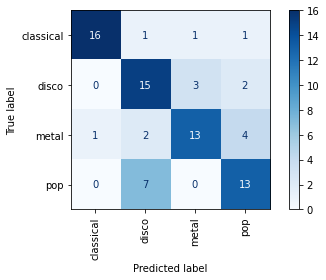

In [35]:
features_task_2 = ["spectral_rolloff_mean", "spectral_centroid_mean", "mfcc_1_mean"]

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    genres=genres_task_2,
    features=features_task_2,
    scaler=sklearn.preprocessing.MinMaxScaler(),
)

classifier = source.diy_classifiers.kNN(k=5, p=2)
classifier.fit(data_frame_x=training_data.x, data_frame_y=training_data.y)
y_pred = classifier.predict(test_data.x)
y_true = test_data.y

error_rate = source.descriptive_statistics.classifier_error_rate(
    predicted_genres=y_pred,
    actual_genres=y_true,
)
print(f"Error Rate: {error_rate:.2f} %")

source.plotting.confusion_matrix(y_true_task1, y_pred_task1, colorbar=True, cmap="Blues")

Strictly going by overlap the next feature to remove would be mfcc_1_mean.

Error Rate: 39.24 %


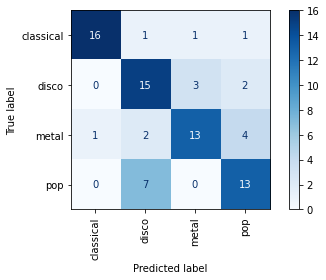

In [36]:
features_task_2 = ["spectral_rolloff_mean", "spectral_centroid_mean"]

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    genres=genres_task_2,
    features=features_task_2,
    scaler=sklearn.preprocessing.MinMaxScaler(),
)

classifier = source.diy_classifiers.kNN(k=5, p=2)
classifier.fit(data_frame_x=training_data.x, data_frame_y=training_data.y)
y_pred = classifier.predict(test_data.x)
y_true = test_data.y

error_rate = source.descriptive_statistics.classifier_error_rate(
    predicted_genres=y_pred,
    actual_genres=y_true,
)
print(f"Error Rate: {error_rate:.2f} %")

source.plotting.confusion_matrix(y_true_task1, y_pred_task1, colorbar=True, cmap="Blues")

Lastly, we can remove either of the spectral components and we have chosen to remove the centroid mean.

Error Rate: 37.97 %


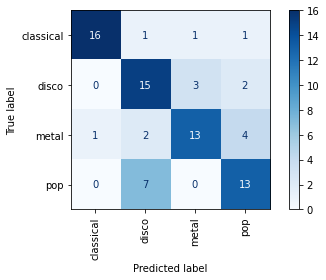

In [37]:
features_task_2 = ["spectral_rolloff_mean"]

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    genres=genres_task_2,
    features=features_task_2,
    scaler=sklearn.preprocessing.MinMaxScaler(),
)

classifier = source.diy_classifiers.kNN(k=5, p=2)
classifier.fit(data_frame_x=training_data.x, data_frame_y=training_data.y)
y_pred = classifier.predict(test_data.x)
y_true = test_data.y

error_rate = source.descriptive_statistics.classifier_error_rate(
    predicted_genres=y_pred,
    actual_genres=y_true,
)
print(f"Error Rate: {error_rate:.2f} %")

source.plotting.confusion_matrix(y_true_task1, y_pred_task1, colorbar=True, cmap="Blues")

For whatever reason removing the tempo does not seem to have a valueable impact on the error rate of the classifier -> this was because the data was not normalized and tempo did not have a large impact on the distance.

Using only one of the features we run the classifier for only four of the genres and take a look at the performance.

Because the assignment mentions four experiments and the previous subtask talks about removing one of the four features, we also plot the confusion matrix for all possibilities of only three features of the given four. (We should probably use cross validation for this instead).

## Task 3
Here Cross Validation is performed to asses which extra 4th feature results in the best model.

Note: this code might take a while to run.


In [52]:
from task03 import task3_feature_selection

data_version = source.data_handling.GENRE_CLASS_DATA_30S
data_set = source.data_handling.read_genre_class_data(data_version)

features_task_3 = ["spectral_rolloff_mean", "tempo", "spectral_centroid_mean", "mfcc_1_mean"]
# Remove Tempo
remove_feature_ind = 1
features_task_3.pop(remove_feature_ind)

add_features = source.mappings.MUSIC_FEATURES_ALL.copy()
for feature in features_task_3:
    add_features.remove(feature)

training_data, _ = source.data_handling.prepare_data(
    data_frame=data_set,
    features=source.mappings.MUSIC_FEATURES_ALL,
    scaler=sklearn.preprocessing.StandardScaler(),
)

add_features_PIs = task3_feature_selection(training_set=training_data, fast_features=features_task_3, add_features=add_features)

best_ind = np.argmin(add_features_PIs)
five_best_inds = np.argpartition(add_features_PIs, 5)[:5]

print(f"The best extra feature to add is: {add_features[best_ind]} with validation Error Rate of: {add_features_PIs[best_ind]}")
print(f"The best 5 extra features are: {[add_features[i] for i in five_best_inds]} with validation Error Rates of: {[add_features_PIs[i] for i in five_best_inds]}")

The best extra feature to add is: rmse_var with validation Error Rate of: 56.034810126582286
The best 5 extra features are: ['rmse_var', 'spectral_rolloff_var', 'mfcc_3_std', 'mfcc_5_std', 'mfcc_1_std'] with validation Error Rates of: [56.034810126582286, 59.71508712806182, 60.102868650336994, 60.734321058688145, 60.971169653131675]


## Task 4

## Cross Validation and Evaluation of PLSR-DA Classifier
Note: this code might take some time to run.

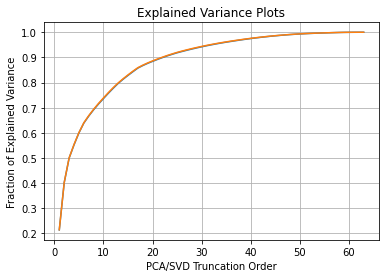

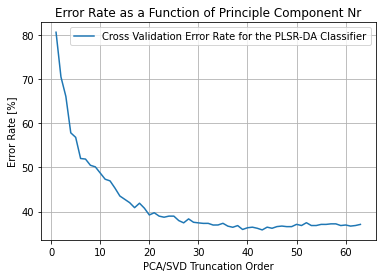

Error Rate: 29.80 %


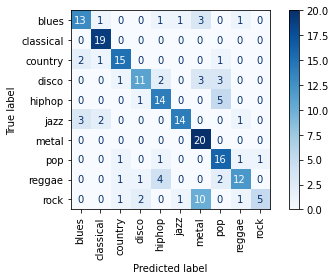

In [53]:
from task04 import validate_plsr_da

data_version = source.data_handling.GENRE_CLASS_DATA_30S
data_frame = source.data_handling.read_genre_class_data(data_version)

genres = list(source.mappings.GENRES.values())

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    features=source.mappings.MUSIC_FEATURES_ALL,
    scaler=sklearn.preprocessing.StandardScaler(),
)

CV_vars = source.descriptive_statistics.cross_validate_pca(training_x=training_data.x, training_y=training_data.y, nr_segments=5)
Scores, P, singular_values, cum_var = source.descriptive_statistics.perform_PCA(training_data.x)

principle_components_PIs = validate_plsr_da(training_set=training_data)

# Plots for evaluation
source.plotting.task04_plots(cum_var=cum_var, CV_vars=CV_vars, pc_PIs=principle_components_PIs)

# PLSR_DA
myClassifier = source.diy_classifiers.PLSR_DA(n_components=20)
myClassifier.fit(training_data.x, training_data.y)

y_genres_pred = myClassifier.predict(test_data=test_data.x)

error_rate = source.descriptive_statistics.classifier_error_rate(
    predicted_genres=y_genres_pred,
    actual_genres=test_data.y,
)
print(f"Error Rate: {error_rate:.2f} %")

source.plotting.confusion_matrix(test_data.y, y_genres_pred, colorbar=True, cmap="Blues")

In [15]:
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm

##### Support Vector Machine
As a comparison to the PLSR we run a sklearn SVM using the default kernel method, without PCA.

Error Rate: 23.74 %


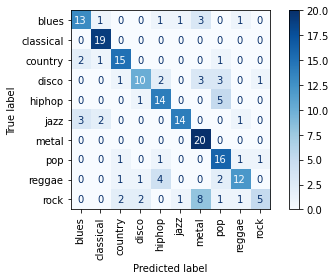

In [43]:
training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    scaler=sklearn.preprocessing.StandardScaler(),
)

classifier = sklearn.svm.SVC(kernel="rbf", decision_function_shape="ovo")
classifier.fit(X=training_data.x, y=training_data.y)

predict_y = classifier.predict(test_data.x)

error_rate = source.descriptive_statistics.classifier_error_rate(
    predicted_genres=predict_y,
    actual_genres=test_data.y,
)
print(f"Error Rate: {error_rate:.2f} %")

source.plotting.confusion_matrix(test_data.y, y_genres_pred, colorbar=True, cmap="Blues")

##### Neural Net
For completeness sake we have also included a simple neural net. The MLP consists of two hidden layers with reducing dimensionality. We have also included dropout layers used in testing to avoid obvious overfitting on specific nodes.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 63)                4032      
                                                                 
 dropout_21 (Dropout)        (None, 63)                0         
                                                                 
 dense_29 (Dense)            (None, 31)                1984      
                                                                 
 dropout_22 (Dropout)        (None, 31)                0         
                                                                 
 dense_30 (Dense)            (None, 15)                480       
                                                                 
 dropout_23 (Dropout)        (None, 15)                0         
                                                                 
 dense_31 (Dense)            (None, 10)               

/home/nbresina/Documents/NTNU/EstimationDetectionClassification/Projects/ttt4275-music-classification/source/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Error Rate: 29.29 %


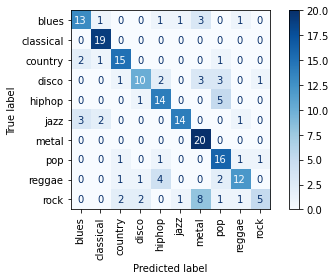

In [51]:
import source.neural_net

all_features = source.mappings.MUSIC_FEATURES_ALL
all_genres = source.mappings.GENRES.values()

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_frame,
    scaler=sklearn.preprocessing.StandardScaler(),
)

classifier = source.neural_net.MLP(input_dimensions=len(all_features), output_dimensions=len(all_genres), verbose=False)
classifier.fit(training_data_x=training_data.x, training_data_y=training_data.y)

predict_y = classifier.predict(test_data_x=test_data.x)

error_rate = source.descriptive_statistics.classifier_error_rate(
    predicted_genres=predict_y,
    actual_genres=test_data.y,
)
print(f"Error Rate: {error_rate:.2f} %")

source.plotting.confusion_matrix(test_data.y, y_genres_pred, colorbar=True, cmap="Blues")

The observed results would imply that PCA does not positively affect the KNN classifier in anyway, but it could do so when using an SVM as the classifier method.